# Experiment 2

Andriy Kurdyukov<br/>
Ege Ögretmen

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark import SparkContext as sc
import random 
import pyspark.sql.functions as sf
import re
from operator import add

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

In [2]:
sparkSession = SparkSession.builder.appName("bonus").config("spark.cores.max", 6).config("spark.driver.memory","8g").config("spark.executor.memory","4g").config("spark.driver.maxResultSize","4g").getOrCreate() 



## Ex 2.1

In [40]:
##ex 2.1
#a)
userRatings = sparkSession.sparkContext.textFile("../dataset/users_libraries.txt")
# separates the user hash and the paper ids
userRatingsRDD = userRatings.map(lambda line: line.split(';')) \
    .map(lambda pair: (pair[0], pair[1].split(',')))


papers = sparkSession.sparkContext.textFile("../dataset/papers.csv")
# separates the paper ids and the words in the abstract of the papers
papersRDD = papers.map(lambda line: line.split(',', 14)) \
    .map(lambda line: (line[0], re.split('\. |\? |, | |"', line[-1]))) \
    .map(lambda data: (data[0], list(filter(len, data[1]))))

n=papersRDD.count()  #number of papers
num_users = userRatingsRDD.count()
#n=userRatingsRDD.flatMap(lambda x:x[1]).map(lambda word:(word,1)).reduceByKey(lambda a, b: a + b).count()#number of distinct items
num_missing_ratings=userRatingsRDD.map(lambda word: n-len(word[1])).sum()# a)  number of all missing ratings 

# n -> we can get this from papersRDD instead of counting them from the users' ratings
max_possible_num_ratings = n * num_users

# num_ratings -> sum number of ratings per user
# num_missing ratings = max_possible_num_ratings - num_ratings
sparsity = num_missing_ratings / max_possible_num_ratings
sparsity

0.9998305694442852

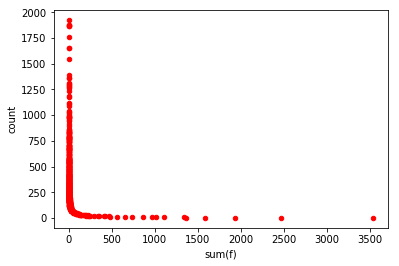

In [41]:
##ex 2.1
#b)

userRatingsRDDOneUserOnePaperPerRow = userRatingsRDD.flatMapValues(lambda x: x)

fields = [
    StructField("user_id", StringType(), False),
    StructField("paper_id", IntegerType(), False)
]
schema = StructType(fields)
usersLikedPapersDF = sparkSession.createDataFrame(userRatingsRDDOneUserOnePaperPerRow.map(lambda row: Row(user_id=row[0], paper_id=int(row[1]))), schema)



df=usersLikedPapersDF.groupBy("user_id").count().sort(desc("count"))
df1=df.select("count").withColumn("f",sf.lit('1')).groupBy("count").agg(sum("f"))

data_panda=df1.toPandas()

data_panda.plot(kind='scatter',x='sum(f)',y='count',color='red')
plt.show()

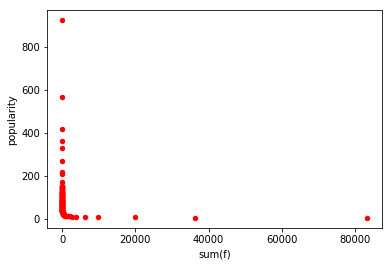

In [42]:
##ex 2.1
#c)
paper_pop=usersLikedPapersDF.groupBy("paper_id").agg(count(usersLikedPapersDF.user_id).alias("popularity"))
#paper_pop.show()
w = Window.orderBy(desc("popularity"))

paper_pop_df=paper_pop.sort(desc("popularity"))

#paper_pop_df.take(4)
paper_pop_ranked=paper_pop_df.withColumn("rn", row_number().over(w))

paper_pop_ranked=paper_pop_ranked.select("popularity").withColumn("f",sf.lit('1')).groupBy("popularity").agg(sum("f"))

paper_pop_ranked_panda=paper_pop_ranked.toPandas()

paper_pop_ranked_panda.plot(kind='scatter',x='sum(f)',y='popularity',color='red')
plt.show()

Both rank-frequency distributions follow a power law: few papers have most likes, few users give most rankings.




## Ex 2.2

In [43]:

from pyspark.sql import functions as F
from pyspark.sql.functions import col

#data_ranked: user uniquely ranked by amount of rankings
w = Window.orderBy(desc("count"))
data_ranked=df.withColumn("rn", row_number().over(w))
#data_ranked.show()
data_ranked.cache()

#joined _df contains user ranking and liked papers ids
rated_for_every_user= data_ranked.join(usersLikedPapersDF,usersLikedPapersDF.user_id == data_ranked.user_id).select("rn","paper_id")
#rated_for_every_user.show()

#amout of disinct papers
papers = rated_for_every_user.select("paper_id").distinct() 

users =  rated_for_every_user.select("rn").distinct() 

#list  of paper ids is collected for every user id
rated_for_every_user_2 = rated_for_every_user.groupBy('rn').agg(F.collect_list("paper_id")).withColumnRenamed("collect_list(paper_id)", "paper_id_list")

#rated_for_every_user_2.take(3)


papers_list= papers.select('paper_id').collect()
def customFunction(row):
  possible_paper_ids = set(papers_list)-set(row.paper_id_list)
  num_liked_paper_ids = len(row.paper_id_list)
    
  irrelevant_paper_ids = random.sample(possible_paper_ids, num_liked_paper_ids)
  return row.rn,irrelevant_paper_ids,row.paper_id_list


sample2 = rated_for_every_user_2.rdd.map(customFunction)

rdd1=sample2.map(lambda x: (x[0] ,x[1])).flatMapValues(lambda x:x).map(lambda x:(x[0],x[1],0)) #unrated  0 column

rdd2=sample2.map(lambda x: (x[0] ,x[2])).flatMapValues(lambda x:x).map(lambda x:(x[0],Row(paper_id=x[1]),1)) #rated

#rdd1.take(3)

rdd_result= rdd1.union(rdd2) #union rated and unrated 
#rdd_result.take(3)



fields = [StructField("user_id", IntegerType(), False),    StructField("paper_id", IntegerType(), False),StructField("rating", IntegerType(), False)]
schema = StructType(fields)

Rating_Matrix_DF = sparkSession.createDataFrame(rdd_result.map(lambda row: Row(user_id=row[0], paper_id=int(row[1].paper_id),rating=int(row[2]))), schema)
Rating_Matrix_DF.cache()
Rating_Matrix_DF.show()

+-------+--------+------+
|user_id|paper_id|rating|
+-------+--------+------+
|    148| 3681996|     0|
|    148|  968743|     0|
|    148| 3251232|     0|
|    148|  142467|     0|
|    148| 4222303|     0|
|    148| 3376872|     0|
|    148|  905078|     0|
|    148| 9835293|     0|
|    148| 1350264|     0|
|    148| 2919540|     0|
|    148| 9759331|     0|
|    148|10697964|     0|
|    148| 6475486|     0|
|    148| 6928685|     0|
|    148|  947531|     0|
|    148| 1350502|     0|
|    148| 1816923|     0|
|    148|  309553|     0|
|    148|  567316|     0|
|    148| 1550294|     0|
+-------+--------+------+
only showing top 20 rows



## Ex 2.3


In [44]:
#Rating_Matrix_DF=Rating_Matrix_DF.limit(100)



als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="paper_id", ratingCol="rating",
          coldStartStrategy="drop")

model = als.fit(Rating_Matrix_DF)


In [46]:
model.write().overwrite().save('./tmp/als_model')

In [47]:
userRecs = model.recommendForAllUsers(10)
userRecs.cache()
userRecs.take(6)

[Row(user_id=148, recommendations=[Row(paper_id=209795, rating=2.7633256912231445), Row(paper_id=126960, rating=2.1602189540863037), Row(paper_id=486037, rating=2.1525564193725586), Row(paper_id=3919458, rating=2.0664994716644287), Row(paper_id=1934366, rating=2.030109167098999), Row(paper_id=3741343, rating=2.015505075454712), Row(paper_id=819069, rating=2.000262498855591), Row(paper_id=532532, rating=1.973921298980713), Row(paper_id=12339844, rating=1.9444444179534912), Row(paper_id=1111692, rating=1.9110350608825684)]),
 Row(user_id=463, recommendations=[Row(paper_id=525767, rating=2.7319490909576416), Row(paper_id=2858326, rating=2.5889687538146973), Row(paper_id=392474, rating=2.5770108699798584), Row(paper_id=700453, rating=2.5064330101013184), Row(paper_id=578262, rating=2.366823196411133), Row(paper_id=691163, rating=2.3417763710021973), Row(paper_id=3097738, rating=2.3132617473602295), Row(paper_id=532532, rating=2.291699171066284), Row(paper_id=13578353, rating=2.277523756027

In [48]:

#find rank corresponding to user hash id

rank=data_ranked.select("user_id","rn").filter(data_ranked.user_id=="1eac022a97d683eace8815545ce3153f").select("rn").take(1)
#print(  int( str(rank[-1])[7] ) )
rn = rank[-1].rn
#rn=int( str(rank[-1]).split("=")[1].split(")")[0]  )
#print( rn  )   #convert to int

user=  userRecs.select("user_id","recommendations").filter( userRecs.user_id==rn)  #find user with given id=rn
user.take(15)

[Row(user_id=329, recommendations=[Row(paper_id=582396, rating=2.727630138397217), Row(paper_id=8147373, rating=2.299933433532715), Row(paper_id=259537, rating=2.2546818256378174), Row(paper_id=99836, rating=2.1714937686920166), Row(paper_id=2516234, rating=2.1497931480407715), Row(paper_id=2600369, rating=2.1185851097106934), Row(paper_id=3924789, rating=2.091446876525879), Row(paper_id=13666618, rating=2.0795085430145264), Row(paper_id=3702781, rating=2.029726266860962), Row(paper_id=2263370, rating=2.028136968612671)])]

## Ex 2.4

Naive training/test splitting is used for simple and straight forward implementation

In [49]:
ratingMatrixTraining, ratingMatrixTest = Rating_Matrix_DF.randomSplit([0.7, 0.3], seed=1234)
(ratingMatrixTraining.count(), ratingMatrixTest.count())

(1159602, 497360)

In [50]:
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(ratingMatrixTraining)
model.write().overwrite().save('./tmp/als_model_training')

In [51]:
userRecs = model.recommendForAllUsers(10)
userRecs.cache()
userRecs.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[[206986, 0.88457...|
|    463|[[1512101, 0.9641...|
|    471|[[6710111, 0.9048...|
|    496|[[13992630, 0.960...|
|    833|[[2055381, 0.9963...|
|   1088|[[9736362, 0.9393...|
|   1238|[[3852158, 0.9986...|
|   1342|[[2534490, 0.9404...|
|   1580|[[2938256, 0.9761...|
|   1591|[[5886131, 1.1432...|
|   1645|[[5886131, 1.0388...|
|   1829|[[448440, 0.87873...|
|   1959|[[125979, 0.99516...|
|   2122|[[733224, 0.91159...|
|   2142|[[6472393, 1.0682...|
|   2366|[[6472393, 1.0632...|
|   2659|[[883959, 0.97851...|
|   2866|[[2174024, 0.9606...|
|   3175|[[1202823, 1.0758...|
|   3749|[[13992630, 1.088...|
+-------+--------------------+
only showing top 20 rows



In [52]:
# reformat such that every recommendation is in a separate row
userRecs2 = userRecs.withColumn('recommendations', explode('recommendations'))
userRecommendations = userRecs2.select('user_id', userRecs2.recommendations.paper_id.alias('paper_id'), userRecs2.recommendations.rating.alias('rating_prediction'))
userRecommendations.show()

+-------+--------+-----------------+
|user_id|paper_id|rating_prediction|
+-------+--------+-----------------+
|    148|  206986|        0.8845787|
|    148| 1403764|       0.88384026|
|    148| 1407136|       0.88324755|
|    148| 5392657|        0.8806099|
|    148| 1404854|       0.87829477|
|    148| 1676236|       0.87819594|
|    148|  472882|       0.87819594|
|    148| 1578041|       0.87819594|
|    148| 1142383|       0.87819594|
|    148|  520114|       0.87819594|
|    463| 1512101|        0.9641173|
|    463|  523019|        0.9594653|
|    463|  514992|         0.942448|
|    463| 9679682|       0.93913716|
|    463|    4129|       0.93265814|
|    463|  902242|        0.9314188|
|    463|  231114|       0.93107814|
|    463|  913811|       0.93006843|
|    463|  618048|       0.92971885|
|    463|  828186|        0.9258579|
+-------+--------+-----------------+
only showing top 20 rows



In [53]:
testPredictions = model.transform(ratingMatrixTest)
testPredictions.cache()
testPredictions.show()

+-------+--------+------+----------+
|user_id|paper_id|rating|prediction|
+-------+--------+------+----------+
|  16526|     148|     1|0.84594613|
|   2956|     148|     1|0.84570485|
|    518|     148|     1|0.91114324|
|    574|     148|     1| 0.8815772|
|     27|     496|     1|0.88435894|
|   1577|     496|     1|0.82992417|
|     31|    1238|     1|0.50888544|
|     27|    1238|     1|0.67163754|
|   5080|    1238|     1|  0.777612|
|  12467|    1238|     1| 0.9277675|
|     86|    1238|     1|0.73358256|
|   1022|    1238|     1| 0.7374877|
|  13647|    1238|     1|0.69376963|
|   4908|    1238|     1| 0.8864511|
|   2518|    1238|     1|  0.736508|
|    656|    1238|     1|0.75505763|
|    521|    1238|     1|0.81181246|
|    133|    1342|     1|0.82065654|
|   3114|    1342|     1| 0.7834982|
|    361|    1342|     1| 0.7506091|
+-------+--------+------+----------+
only showing top 20 rows



In [54]:
evaluator = RegressionEvaluator(labelCol='rating', predictionCol='prediction', metricName='rmse')
evaluator.evaluate(testPredictions)

0.35111265635596295

In [55]:
w = Window.partitionBy('user_id').orderBy(col('prediction').desc())
rankedTestPredictions = testPredictions.withColumn('rank', sf.rank().over(w))
rankedTestPredictions.show()

+-------+--------+------+----------+----+
|user_id|paper_id|rating|prediction|rank|
+-------+--------+------+----------+----+
|    148|  296805|     1|0.87144893|   1|
|    148|  519676|     1|0.86740875|   2|
|    148|  888716|     1|0.86740875|   2|
|    148|  549102|     1|0.86740875|   2|
|    148| 1203660|     1|0.86740875|   2|
|    148| 1429916|     1|0.86740875|   2|
|    148|  591342|     1|0.86740875|   2|
|    148|  836875|     1|0.86740875|   2|
|    148|  482100|     1|0.86740875|   2|
|    148| 1421600|     1|0.86740875|   2|
|    148|  511913|     1|0.86740875|   2|
|    148|  258727|     1|0.86740875|   2|
|    148|  232975|     1|0.86740875|   2|
|    148|  258683|     1|0.86740875|   2|
|    148|  699556|     1|0.86740875|   2|
|    148|  929832|     1|0.86740875|   2|
|    148| 1627908|     1|0.86740875|   2|
|    148| 1420470|     1|0.86740875|   2|
|    148| 1422784|     1|0.86740875|   2|
|    148| 1574685|     1|0.86740875|   2|
+-------+--------+------+---------

In [56]:
top10Recommendations = rankedTestPredictions.filter(col('rank') <= 10)
top10Recommendations.show()

+-------+--------+------+----------+----+
|user_id|paper_id|rating|prediction|rank|
+-------+--------+------+----------+----+
|    148|  296805|     1|0.87144893|   1|
|    148|  519676|     1|0.86740875|   2|
|    148|  888716|     1|0.86740875|   2|
|    148|  549102|     1|0.86740875|   2|
|    148| 1203660|     1|0.86740875|   2|
|    148| 1429916|     1|0.86740875|   2|
|    148|  591342|     1|0.86740875|   2|
|    148|  836875|     1|0.86740875|   2|
|    148|  482100|     1|0.86740875|   2|
|    148| 1421600|     1|0.86740875|   2|
|    148|  511913|     1|0.86740875|   2|
|    148|  258727|     1|0.86740875|   2|
|    148|  232975|     1|0.86740875|   2|
|    148|  258683|     1|0.86740875|   2|
|    148|  699556|     1|0.86740875|   2|
|    148|  929832|     1|0.86740875|   2|
|    148| 1627908|     1|0.86740875|   2|
|    148| 1420470|     1|0.86740875|   2|
|    148| 1422784|     1|0.86740875|   2|
|    148| 1574685|     1|0.86740875|   2|
+-------+--------+------+---------

For user_id = 148 there are more than 10 papers with the same prediction rating in top 10

In [57]:
top10Recommendations.filter(col('user_id') == 666).show()

+-------+--------+------+----------+----+
|user_id|paper_id|rating|prediction|rank|
+-------+--------+------+----------+----+
|    666| 1513011|     1| 0.8862874|   1|
|    666| 2932515|     1|0.88082105|   2|
|    666| 3390622|     1| 0.8801514|   3|
|    666| 4447018|     1|0.87008756|   4|
|    666| 6472226|     1|0.86853373|   5|
|    666| 2816590|     1| 0.8683074|   6|
|    666|  352015|     1| 0.8650152|   7|
|    666| 5487970|     1|0.86232406|   8|
|    666|  327194|     1|0.86183965|   9|
|    666| 5014726|     1| 0.8561163|  10|
+-------+--------+------+----------+----+



Here it can be seen that user_id = 666 have exactly 10 recommended papers in top 10

## Ex 2.5

In [58]:
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating",
          coldStartStrategy="drop")
grid = ParamGridBuilder().addGrid(als.rank, [10, 25, 50]).build()
evaluator = RegressionEvaluator(labelCol='rating', predictionCol='prediction', metricName='rmse')
cv = CrossValidator(estimator=als, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(Rating_Matrix_DF)
cvModel.avgMetrics

[0.356473474927107, 0.3394420198055706, 0.3357951452362703]

In [65]:
grid2 = ParamGridBuilder() \
    .addGrid(als.rank, [10, 25, 50]) \
    .addGrid(als.maxIter, [10, 15, 20]) \
    .build()

In [66]:
[[(param.name, value) for param, value in param_dict.items()] for param_dict in grid2]

[[('rank', 10), ('maxIter', 10)],
 [('rank', 10), ('maxIter', 15)],
 [('rank', 10), ('maxIter', 20)],
 [('rank', 25), ('maxIter', 10)],
 [('rank', 25), ('maxIter', 15)],
 [('rank', 25), ('maxIter', 20)],
 [('rank', 50), ('maxIter', 10)],
 [('rank', 50), ('maxIter', 15)],
 [('rank', 50), ('maxIter', 20)]]

In [59]:
cv2 = CrossValidator(estimator=als, estimatorParamMaps=grid2, evaluator=evaluator)
cvModel2 = cv2.fit(Rating_Matrix_DF)
cvModel2.avgMetrics

[0.35647347492710696,
 0.3482352897666724,
 0.3453458405886585,
 0.3394420198055706,
 0.33351246467951556,
 0.3314477498510757,
 0.3357951452362703,
 0.3310051951619812,
 0.32939203146999024]

The best hyperparameter configuration is achieved with maxIter = 20 and rank = 50 with RMSE of 0.329. This shows that further experiments should be done with increasing rank and maxIter. However we can also see that we have diminishing returns while increasing the values of the hyperparameters.